<a href="https://colab.research.google.com/github/sushily1997/Rice_Disease_Classifire/blob/main/Rice_Leaf_Disease_Classifire_Using__Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# import important libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, callbacks
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


In [2]:
# Creating a 'earlystopping' function to trigger termination when desired loss or accuracy is achieved.
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAccuracy is greater than 96% so terminating training!")
      self.model.stop_training = True
# elif (logs.get('loss') < 0.3):
# print("\nLoss is less than 0.3 so terminating training!")
# self.model.stop_training = True
callbacks = myCallback()

# **1. LOADING DATA :**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/archive (1)/RiceLeafsDisease/train",
                                                              shuffle=True,
                                                              image_size=(256,256),
                                                              batch_size=32)

Found 2100 files belonging to 6 classes.


In [5]:
testing = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/archive (1)/RiceLeafsDisease/validation",
shuffle=True,
image_size=(256,256),
batch_size=32
)

Found 528 files belonging to 6 classes.


# **2. DATA EXPLORATION :**

In [6]:
disease = dataset.class_names
disease

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [7]:
# .take() method is used to pickup a batch from the complete data, where each batch contains 32 images (as we specified earlier).
for img,lab in dataset.take(1):
    print(img.shape)
    print(lab.numpy())


(32, 256, 256, 3)
[2 3 0 3 5 4 5 5 5 4 3 2 1 2 5 0 1 3 3 3 0 2 0 5 4 0 1 2 4 5 4 2]


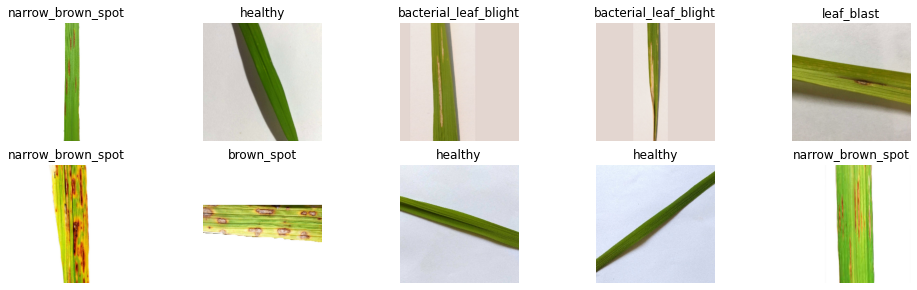

In [8]:
plt.figure(figsize=(17,10))
for img,lab in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(4,5,i+1),
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(disease[lab[i]])
    plt.axis('off')

# **3. DATA PREPARATION :**

In [9]:
len(testing)//2 # No. of batches in test data.

8

**17 batches x 1 batch with 32 image = 544 images.**

In [10]:
# traing-test split,
valid = testing.take(8)


**As, valid already has 8 batches from top, we can copy remaining into 'test' variable using
.skip() method to keep everthing except these 8 batches from top**

In [11]:
test = testing.skip(8)


In [12]:
len(valid), len(test), len(dataset)


(8, 9, 66)

**8 + 9 = 17 batches & 66 batches of training data, we are good to go now,**

In [13]:
# CACHING & PREFETCHING TO MAKE THE PIPELINE HIGH PERFORMANT :
dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# **4. PIPELINES :**

* ### **RESIZING & RESCALING :**

In [14]:
# Rescaling & Resizing data for testing and smoother training.
scale = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.Resizing(256,256),
tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

* ### **DATA AUGMENTATION :**

In [15]:
# Adding custom images using data augmentation technique for better accuracy.
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                        ])

**..now that we have scaling and data augmentation layer ready, we can proceed further with
our model building part,**

* ### **MODEL BUILDING :**

In [59]:
model = models.Sequential([
scale,
data_augmentation,
# Add CNNs and maxpooling layers (trail & error work)
layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,256,256,3)),
layers.MaxPooling2D((2,2)),
layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Flatten(),
layers.Dense(64, activation='relu'),
layers.Dense(6, activation='softmax')
])
model.build(input_shape=(32,256,256,3))

In [60]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [61]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)


In [19]:
%%time
his = model.fit(
 dataset,
 epochs=50,
 batch_size=32,
 verbose=1,
 validation_data=valid,
 callbacks=[callbacks]
)


Epoch 1/50
66/66 [==============================] - 384s 6s/step - loss: 1.7464 - accuracy: 0.2152 - val_loss: 1.6997 - val_accuracy: 0.2578
Epoch 2/50
66/66 [==============================] - 308s 5s/step - loss: 1.5324 - accuracy: 0.3562 - val_loss: 1.4129 - val_accuracy: 0.3945
Epoch 3/50
66/66 [==============================] - 307s 5s/step - loss: 1.3967 - accuracy: 0.4210 - val_loss: 1.2882 - val_accuracy: 0.4883
Epoch 4/50
66/66 [==============================] - 299s 4s/step - loss: 1.2948 - accuracy: 0.4786 - val_loss: 1.3048 - val_accuracy: 0.4180
Epoch 5/50
66/66 [==============================] - 299s 4s/step - loss: 1.0686 - accuracy: 0.5852 - val_loss: 1.0710 - val_accuracy: 0.5938
Epoch 6/50
66/66 [==============================] - 309s 5s/step - loss: 0.8956 - accuracy: 0.6590 - val_loss: 0.9935 - val_accuracy: 0.6367
Epoch 7/50
66/66 [==============================] - 301s 5s/step - loss: 0.7527 - accuracy: 0.7124 - val_loss: 0.8168 - val_accuracy: 0.6602
Epoch 8/50
66

In [20]:
score = model.evaluate(test)


9/9 [==============================] - 23s 2s/step - loss: 0.6507 - accuracy: 0.8566


In [21]:
his.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
loss = his.history["loss"]
val_loss = his.history["val_loss"]
acc = his.history["accuracy"]
val_acc = his.history["val_accuracy"]


In [23]:
len(acc), len(val_acc)

(50, 50)

Text(0.5, 1.0, 'Training & Validation Accuracy')

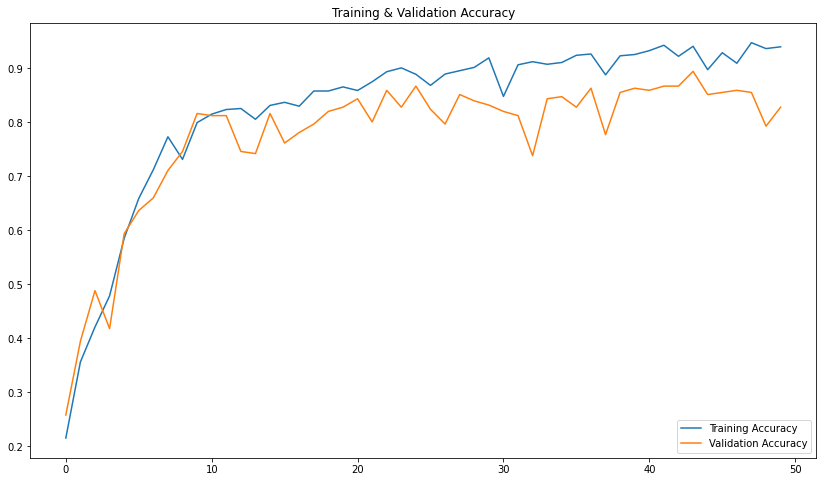

In [24]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')

**This graph shows that even increasing the epoch does not make much difference to the
accuracy. Let's look at the graph of loss and conclude.**

Text(0.5, 1.0, 'Training & Validation Loss')

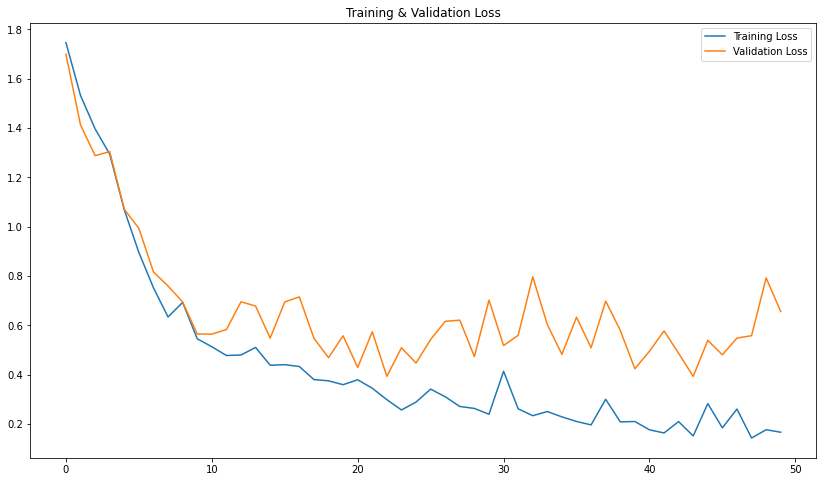

In [25]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training & Validation Loss')

**It is possible that the loss would have reduced further, but 0.112 sounds great to me.**

In [50]:
batch1 =test.take(1)


1/1 [==============================] - 1s 1s/step

True : leaf_scald
Predicted : leaf_scald


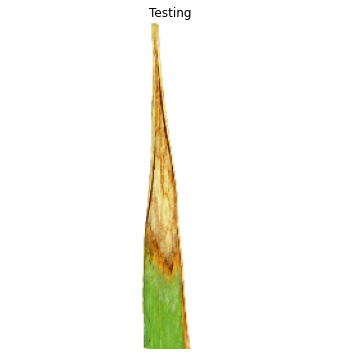

In [51]:
plt.figure(figsize=(6,6))
for img, clf in batch1:
    random_img = img[0].numpy().astype('uint8')
    typ = clf[0].numpy()
    plt.imshow(random_img)
    plt.axis('off')
    plt.title("Testing")
    prediction = model.predict(img)
print("\nTrue :",disease[typ])
print("Predicted :",disease[np.argmax(prediction[0])])

In [52]:
def pred(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = tf.expand_dims(array,0)
    prediction = model.predict(array)
    clf = disease[np.argmax(prediction[0])]
    conf = round(100 * (np.max(prediction[0])), 2)
    return clf, conf

1/1 [==============================] - 0s 50ms/step


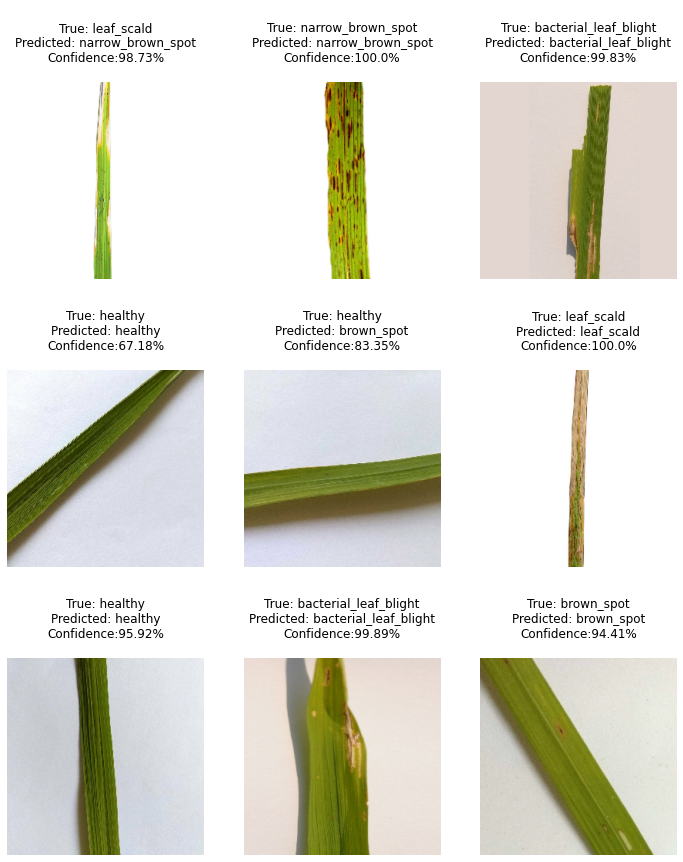

In [53]:
plt.figure(figsize=(12,15))
for img, lab in batch1:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        prediction, confidence = pred(img[i].numpy())
        true = disease[lab[i]]
        plt.title(f"\nTrue: {true}\nPredicted: {prediction}\nConfidence:{confidence}%\n")
        plt.axis('off')

In [62]:
import os
model_version= max([float(i) for i in os.listdir("models")]) + 0.1

print(f"\nCurrent Version : {model_version-0.1}\nRun below cell to createversion : {model_version}")


Current Version : 0.1
Run below cell to createversion : 0.2


# **SAVE MODEL :**

In [63]:
model_version = 0.1
model.save(f"models/{model_version}")
print(f"Version {model_version} Created Successfully.")


Version 0.1 Created Successfully.
